In [1]:
GUROBI_TIME_LIMIT = 432

# Project 3: Gurobi vs Lasso

| Name | EID |
| --- | --- |
| Palak Agarwal| pa9797 |
| Mahika Bansal| mh62835 |
| Brandt Green | bwg537 |
| Chandler Wrenn | clw4642 |

In [2]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import os
import seaborn as sns; sns.set_theme()
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Set a random seed so that we can get consistent shuffling for each run. Helpful for debuggin purposes.
np.random.seed(seed=42)

## Data extraction and preparation

Read in the the training and testing data and insert a new column in the beginning labeled 'X0' which will consist of all $1$s that will act as our intercept term.

In [3]:
train_data = pd.read_csv('training_data.csv')
test_data = pd.read_csv('test_data.csv')

# We separate out a set of the orginal data here before messing with anything because we will want to feed it just like this into scikit learn much later on.
X_train_og, y_train_og = train_data.drop(columns='y').to_numpy(), train_data['y'].to_numpy()

train_df = train_data.copy()
train_df.insert(1,column='X0',value=np.ones(len(train_data)))

test_df =test_data.copy()
test_df.insert(1,column='X0',value=np.ones(len(test_data)))

train_df.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,8.53615,1.00000,-1.53541,0.71889,-2.09915,-0.44284,-0.59898,-1.64257,0.20776,0.76064,...,0.36187,1.79310,-0.63129,-0.06175,0.51105,0.48875,-0.61277,-0.47105,-1.13978,-0.26077
1,4.80834,1.00000,-1.73461,0.55198,-2.14767,-1.55294,1.51491,-1.14397,0.73759,1.32124,...,-0.67798,-0.16568,0.06540,0.13716,1.25820,-0.12083,-1.56483,-0.24256,-0.00183,1.18745
2,-1.53043,1.00000,0.09726,0.10763,-0.19422,0.33545,-0.40820,0.13326,0.70618,0.39497,...,1.10880,0.33379,0.28205,-1.08629,-0.11535,0.25786,-0.08884,-0.75123,1.45061,0.29059
3,-0.42824,1.00000,-0.06770,0.55784,0.70085,-1.12138,1.72227,0.61353,0.70091,-0.41798,...,0.69251,-0.35099,0.62456,0.43452,-0.36741,-1.14468,-0.13652,-0.55721,0.41630,0.48449
4,0.56669,1.00000,0.48873,0.21148,0.56839,0.64684,0.16387,-0.00215,0.12514,0.49357,...,-0.00060,1.07528,0.18228,-1.13846,0.10609,0.54464,-0.38349,-0.42577,2.66765,-0.05075


In [4]:
# Get a list of shuffled indices from the training data and use the indices to create a new, shuffled training df
shuffled_indices = np.random.permutation(train_df.index)
shuffled_train_df = train_df.iloc[shuffled_indices]

# Separate out the X and y variables from the training and test sets. Also, convert them to numpy arrays.
X_train, y_train = shuffled_train_df.drop(columns='y').to_numpy(), shuffled_train_df['y'].to_numpy()
X_test, y_test = test_df.drop(columns='y').to_numpy(), test_df['y'].to_numpy()

Now that everything is shuffled, we need to get our k_fold indices. We can use sklearns Kfold function because it helps us abstract away some of the annoying complexities, such as how to handle distributing the data points to folds when the data is not perfectly divisible by the number of folds. 

The KFolds class is a generator that will iteratively yield the training and testing indices of each k-fold in a tuple. In the below cell, we loop through each fold and we put all of the indices in a dictionary, which seems like too much effort and extra complexity for now, but it will make our code later on much more readable!

In [5]:
num_of_k_folds = 10
split_indices = KFold(n_splits=num_of_k_folds).split(X_train)

k_folds_dict:dict = {}
for i, indices in enumerate(split_indices):
    index_dict = {}
    # The training indices are in the first item of the tuple and the testing indices are in the second.
    index_dict['train_indices'] = indices[0]
    index_dict['test_indices'] = indices[1]
    k_folds_dict[i] = index_dict

# Sample of the dicitionary printed for the first fold
print(k_folds_dict[0])

{'train_indices': array([ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201,

## Picking the optimal K with Gurobi

In [6]:
# Create a dataframe to store the cross validation results for the gurobi optimization
# We will be updating this later on in our Gurobi loop

k_options = np.arange(5,51,5)

gurobi_results_df = pd.DataFrame(index=k_folds_dict.keys(),columns=k_options)
gurobi_results_df

,5,10,15,20,25,30,35,40,45,50
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Set some basic parameters that we will need later on!

In [7]:
M = 50 # Make sure this number is big enough!! M of like 200ish doesn't work. So be wary

# Number of independent variables in our problem. This will not include the intercept term
beta_num = X_train.shape[1] - 1

# The betas are continuous, but the z variables will be binary
v_type = ['C']*(beta_num+1) + ['B']*beta_num

# Betas can be negative in this problem. But the z variables are binary 1/0
lower_bounds = [-M]*(beta_num+1) + [0]*beta_num

In [8]:
def solve_gurobi(X,y,k):
    """Returns an array of the 51 beta coefficients  which are optimal betas, solved with gurobi.
    Inputs: X and y data as numpy arrays. And the k value.
    """

    # Create the matrices for the quadratic and linear objective functions
    quadratic_obj = np.zeros(shape=(2*beta_num+1,2*beta_num+1))
    quadratic_obj[:(beta_num+1),:(beta_num+1)] = X.T @ X

    linear_obj = np.zeros(shape=beta_num*2+1)
    linear_obj[:(beta_num+1)] = -2*y.T @ X


    # Now we can fill in the equations for gurobi
    sense = []
    b = []

    # We need two big M constraints for each beta and 1 constraint to make sure beta number = k 
    num_constraints = beta_num * 2 + 1
    A = np.zeros(shape=(num_constraints,len(linear_obj)))


    # Constraint that the number of independent betas should sum to <= k. Excludes the intercept beta.
    A[0,(beta_num+1):] = 1
    sense.append('<')
    b.append(k)

    # Add the big M constraints
    # Skip the intercept term 
    # Start on row index 1 (because 0 is set above)
    row_index = 1
    for i in range(1,beta_num+1):
        # Set constraint that beta must be less than M
        A[row_index,i] = 1
        A[row_index, i + beta_num] = -M
        sense.append('<')
        b.append(0)
        row_index += 1

        # Set constraint that beta must be greater than -M
        A[row_index,i] = 1
        A[row_index, i + beta_num] = M
        sense.append('>')
        b.append(0)

        row_index += 1

    # Now put the equations into Gurobi and solve!
    regression_mod = gp.Model()
    # Important to set the lower bound here because otherwise Gurobi will default to 0.
    regression_mod_x = regression_mod.addMVar(len(linear_obj), lb=lower_bounds, vtype=v_type)
    portMod_con = regression_mod.addMConstrs(A, regression_mod_x, sense, b)
    regression_mod.setMObjective(quadratic_obj,linear_obj,0,sense=gp.GRB.MINIMIZE)

    regression_mod.Params.OutputFlag = 0 
    regression_mod.Params.TimeLimit = GUROBI_TIME_LIMIT
    regression_mod.optimize()

    # Return all of the betas as the results!!
    return regression_mod_x.x[:(beta_num+1)]

# pd.DataFrame(solve_gurobi(X_train,y_train,10))

Here we, just define two helper functions for evaluating the results of the models.

In [9]:
def predict_y(X, betas):
    """Outputs the predicted y values"""
    return X @ betas

def sse(y_true, y_predict):
    """Returns the sum of squared errors."""
    return sum((y_true - y_predict)**2)

In [10]:
# No need to run the Gurboi optimization if we already have the results stored in a csv!
if os.path.exists('gurobi_sse_results.csv'):
    gurobi_results_df = pd.read_csv('gurobi_sse_results.csv')
else:

    for k_fold, indices_dict in k_folds_dict.items():

        # Get our training folds and testing folds
        X_train_folds, y_train_folds = X_train[indices_dict['train_indices']], y_train[indices_dict['train_indices']]
        X_test_fold, y_test_fold = X_train[indices_dict['test_indices']], y_train[indices_dict['test_indices']]

        # Now let's try out all of the possible k values
        for k in k_options:
            optimal_betas = solve_gurobi(X_train_folds,y_train_folds,k)

            validation_mse = sse(y_test_fold,predict_y(X_test_fold,optimal_betas))

            gurobi_results_df.loc[k_fold,k] = validation_mse  

    gurobi_results_df.to_csv('gurobi_sse_results.csv',index=False)

gurobi_results_df

,5,10,15,20,25,30,35,40,45,50
0,121.08483,83.22601,84.98515,82.43595,87.58834,95.66110,97.65884,97.40345,96.66076,97.57031
1,76.27096,68.72295,85.44507,91.70347,87.32364,95.86751,96.42208,96.91586,100.55214,101.13772
2,76.40846,62.50184,70.91066,83.65107,75.81232,73.46238,78.72707,80.83133,79.28233,79.96562
3,72.64028,62.72359,71.70770,71.71293,70.69936,79.46967,80.39510,77.86652,77.20627,78.33711
4,118.95958,82.00438,83.84794,80.40048,80.64813,86.74073,90.89855,87.42634,85.88534,86.93229
5,82.97925,61.88108,65.54801,59.53692,75.45312,67.36771,61.14406,66.13959,67.73551,67.36372
6,76.18434,65.08857,69.81931,70.62222,68.35383,70.47346,67.89549,71.89055,75.20079,75.06871
7,60.29282,48.66334,59.89032,58.02635,56.43211,55.66685,54.96695,60.79733,64.49536,63.55508
8,133.75785,93.39369,99.85986,105.95280,98.82562,105.08918,104.69604,103.96380,104.83067,104.08194
9,95.53616,75.76057,87.45220,89.38065,81.48977,84.18368,88.06178,84.99322,84.14878,86.44153


In [11]:
# We aggregate the results of each lambda across all folds by summing each folds SSE to get an "Aggregate SSE"
total_sse_per_fold_g = gurobi_results_df.sum()
pd.DataFrame(total_sse_per_fold_g,columns=['Total SSE'])

,Total SSE
5,914.11453
10,703.96601
15,779.46622
20,793.42285
25,782.62626
30,813.98226
35,820.86596
40,828.22798
45,835.99795
50,840.45402


We can plot the results to see how the total error evolves as the K changes.

Text(0, 0.5, 'Aggregate SSE Across All Folds')

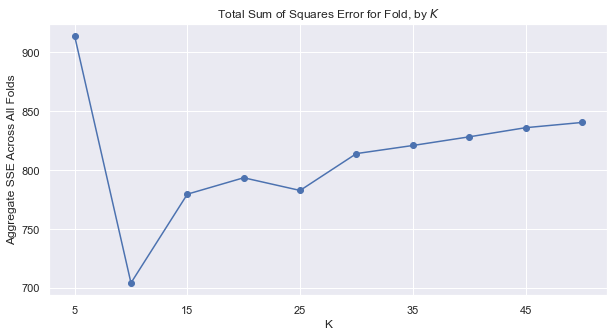

In [12]:
total_sse_per_fold_g.plot(figsize=(10,5),marker='o')
plt.title('Total Sum of Squares Error for Fold, by $K$')
plt.xlabel('K')
plt.ylabel('Aggregate SSE Across All Folds')

Looks like we are able to capture a minimum here where k = 10.

In [13]:
# Store the best K for later use
best_k = int(total_sse_per_fold_g.sort_values().index[0])
print(f'The best lambda = {best_k}')

The best lambda = 10


Fit the entire data set using the best lambda calculated above and finally, test on the hold out set.

In [14]:
# Creating a master df here to store the evaluation metrics for both Gurobi optimization and Lasso. That will make for easy comparison later.
best_results = pd.DataFrame(columns=['SSE','MSE','R_Squared'])

In [15]:
# Create and fit the model with the best K
best_gurobi_betas = solve_gurobi(X_train,y_train,k=best_k)

# Predict on hold out set and put the metrics into the best results df
gurobi_predictions = predict_y(X_test,best_gurobi_betas)
gurobi_sse = sse(y_test,gurobi_predictions)
gurobi_mse = mean_squared_error(y_test,gurobi_predictions)
gurobi_r_squared = r2_score(y_test,gurobi_predictions)

best_results.loc['Gurobi_Method_Metrics'] = [gurobi_sse,gurobi_mse,gurobi_r_squared]
best_results

Academic license - for non-commercial use only - expires 2022-09-15
Using license file C:\Users\User\gurobi.lic


,SSE,MSE,R_Squared
Gurobi_Method_Metrics,116.82720,2.33654,0.85867


## Picking Lambda with scikitlearn

Cross validation is so much easier when scikit does it for us!

In [16]:
lasso_model_cv = linear_model.LassoCV(cv=10).fit(X_train_og,y_train_og)
best_lambda = lasso_model_cv.alpha_
print(f'The best lambda = {best_lambda}')

The best lambda = 0.07638765995113514


Fit the entire data set using the best lambda calculated above and finally, test on the hold out set.

In [17]:
# Create and fit the best lasso.
best_lasso_model = Lasso(best_lambda).fit(X_train_og, y_train_og)

# Predict on hold out set and put the metrics into the best results df

# We can ignore that column of 1s that was added earlier for the lasso model
lasso_predictions = best_lasso_model.predict(X_test[:,1:])
lasso_sse = sse(y_test,lasso_predictions)
lasso_mse = mean_squared_error(y_test,lasso_predictions)
lasso_r_squared = r2_score(y_test,lasso_predictions)

best_results.loc['Lasso_Metrics'] = [lasso_sse, lasso_mse, lasso_r_squared]

## Comparison

In [18]:
best_results

,SSE,MSE,R_Squared
Gurobi_Method_Metrics,116.82720,2.33654,0.85867
Lasso_Metrics,117.48174,2.34963,0.85788


We can also look at how many non-intercept betas are retained with each method. Assuming we get similiar results, we should have a bias towards the least complex model, meaning the one with fewer betas.

In [19]:
print(f'The number of non-intercept betas using the lasso method =  {(best_lasso_model.coef_ != 0).sum()}')
print(f'The number of non-intercept betas using the Gurobi Optimization method =  {(best_gurobi_betas != 0).sum()-1}')

The number of non-intercept betas using the lasso method =  17
The number of non-intercept betas using the Gurobi Optimization method =  10
